# Decision Tree C4.5

+ Author: Jingxuan Yang
+ E-mail: yangjx20@mails.tsinghua.edu.cn
+ Page: www.jingxuanyang.com
+ Date: 2021-05-14
+ Project: Pattern Recognition, homework 11
+ Purpose: Implement decision tree C4.5 algorithm on Sougou corpus dataset

## Import packages

In [10]:
import os
import random
import numpy as np
from scipy import io, stats
import matplotlib.pyplot as plt

## Define function to split the dataset

In [11]:
def split():
    """Split dataset into 3:1:1 sub datasets to train, validate, and test, respectively.
    """
    train_split = open('train_split.txt','w')
    validate_split = open('validate_split.txt','w')
    test_split = open('test_split.txt','w')

    for i in range(14400):
        rand = random.random()
        if rand<0.2:
            validate_split.write(f'{i}\n')
        elif rand>0.8:
            test_split.write(f'{i}\n')
        else:
            train_split.write(f'{i}\n')

    train_split.close()
    test_split.close()
    validate_split.close()

## Define data lodaer class

including functions:
+ `__init__(self, root_path='../data/Sogou_webpage.mat', split_path='./')`
+ `get_item(self, mode='train')`

In [12]:
class DataLoader:
    """Load dataset and split it into train, validate, and test sub datasets.
    """
    def __init__(self, root_path='../data/Sogou_webpage.mat', split_path='./'):
        """Initialize class, split dataset if necessary, and obtain splitted index.
        :param root_path: relative path of dataset
        :param split_path: path split symbol
        """
        self.root_path = root_path
        self.data = None
        self.label = None

        if not os.path.exists('validate_split.txt'):
            split()

        with open(os.path.join(split_path,'train_split.txt')) as f:
            self.train_split = [int(i.strip()) for i in f.readlines()]
        with open(os.path.join(split_path,'validate_split.txt')) as f:
            self.validate_split = [int(i.strip()) for i in f.readlines()]
        with open(os.path.join(split_path,'test_split.txt')) as f:
            self.test_split = [int(i.strip()) for i in f.readlines()]
        

    def get_item(self, mode='train'):
        """Get data and label for train, validate, and test.
        :param mode: str, assert which sub dataset to be obtained
        :return self.data: list, sub dataset
        :return self.label: list, labels
        """
        if self.data is None:
            data = io.loadmat(self.root_path)
            self.data = data['wordMat'][:]
            self.label = data['doclabel'][:]

        if mode == 'train':
            return self.data[self.train_split], self.label[self.train_split]
        if mode == 'validate':
            return self.data[self.validate_split], self.label[self.validate_split]
        if mode == 'test':
            return self.data[self.test_split], self.label[self.test_split]


## Define decision tree class

including functions:
+ `__init__(self)`
+ `GenerateTree(self, thresh=1e-1, data=None, label=None)`
+ `SplitNode(self, thresh=1e-1, data=None, label=None, pos=0)`
+ `SelectFeature(self, data, label, thresh)`
+ `Impurity(self, data, label)`
+ `Decision(self, data=None, label=None)`
+ `Prune(self,data=None, label=None)`
+ `EvalAccuracy(self, rule, data, label, pred)`

In [13]:
class DecisionTree:
    """Generate decision tree and test its accuracy.
    """
    def __init__(self):
        """Initialize decision tree.
        :attribute tree: list of nodes, [feature, left child, right child, parent] 
        :attribute leaf: list, [position, label]
        :attribute rule: list, [feature, bool], generated from the decision tree
        """
        self.tree = []
        self.leaf = []
        self.rule = []
        root = [-1,-1,-1,0]
        self.tree.append(root)


    def GenerateTree(self, thresh=1e-1, data=None, label=None):
        """Generate decision tree.
        :param thresh: float, classification threshold
        :param data: list, dataset
        :param label: list, labels
        """
        if data is None:
            return

        self.SplitNode(thresh=thresh, data=data, label=label, pos=0)

        # generate rules from decision tree
        for leaf in self.leaf:
            rule = []
            if leaf[0] == 1:
                self.rule.append(np.array(rule))
                # no node but a leaf
                break
            node = self.tree[leaf[0]]
            while True:
                val = 0
                if node[3] > 0:
                    val = 1
                rule.insert(0,[self.tree[abs(node[3])][0],val])
                if abs(node[3]) == 1:
                    break
                node = self.tree[abs(node[3])]
            self.rule.append(np.array(rule))

        self.rule = np.array(self.rule, dtype=object)


    def SplitNode(self, thresh=1e-1, data=None, label=None, pos=0):
        """Split nodes of decision tree.
        :param thresh: float, classification threshold
        :param data: list, dataset
        :param label: list, labels
        :param pos: position of leaf node
        """
        if data is None:
            return

        if (set(label.reshape(-1).tolist())) == 1:
            # if node is already pure
            self.tree.append([-1,-1,-1, pos])
            self.leaf.append([len(tree)-1,label[0]])
            return 
        
        feat = self.SelectFeature(data,label,thresh)
        if feat == -1:
            # if it's time to stop
            self.tree.append([-1,-1,-1,pos])
            self.leaf.append([len(self.tree)-1,stats.mode(label.reshape(-1))[0][0]])
            return 
        
        # otherwise, we split data into left nodes and right nodes
        self.tree.append([feat,-1,-1,pos])
        left_node = data[data[:,feat] == 0]
        left_label = label[data[:,feat] == 0]
        left_node[:,feat] = -1
        right_node = data[data[:,feat] == 1]
        right_label = label[data[:,feat] == 1]
        right_node[:,feat] = -1

        # call SplitNode recursively to split all nodes
        pos = len(self.tree)-1
        self.SplitNode(thresh=thresh,data=left_node,label=left_label,pos=-pos)
        self.SplitNode(thresh=thresh,data=right_node,label=right_label,pos=pos)
    
    
    def SelectFeature(self, data, label, thresh):
        """Select features of decision tree.
        :param data: list, dataset
        :param label: list, labels
        :param thresh: float, classification threshold
        :return feature: int, one of the features
        """
        feature = -1
        gain_ratio = thresh
        imp_root = self.Impurity(data,label)

        for i in range(data.shape[1]):
            if (data[:,i] == -1).any():
                # if feature is used before
                continue
            else:
                left_node = data[data[:,i] == 0]
                left_label = label[data[:,i] == 0]
                right_node = data[data[:,i] == 1]
                right_label = label[data[:,i] == 1]

                if left_label.size == 0 or right_label.size == 0:
                    continue
                
                # calculate impurity gain
                priori = np.array([left_label.size,right_label.size]) / data.shape[0]
                gain = imp_root - priori[0] * self.Impurity(left_node,left_label) - priori[1] * self.Impurity(right_node,right_label)
    
                if gain > gain_ratio:
                    gain_ratio = gain
                    feature = i

        return feature
    

    def Impurity(self, data, label):
        """Calculate impurity using cross entropy.
        :param data: list, dataset
        :param label: list, labels
        :return: float, impurity
        """
        p_k = []
        label_set = set(label.reshape(-1).tolist())

        for i in label_set:
            p_k.append((label==i).sum())
        p_k = np.array(p_k) / label.size

        return (-p_k * np.log2(p_k)).sum()
    

    def Decision(self, data=None, label=None):
        """Make predictions to dataset.
        :param data: list, dataset
        :param label: list, labels
        :return: float, prediction accuracy
        """
        if data is None:
            return
        
        predict = -1 * np.ones((data.shape[0],1))
        decided = np.ones(predict.shape[0]).astype(bool)

        for i,rule in enumerate(self.rule):
            index = np.ones(predict.shape[0]).astype(bool)
            for judge in range(rule.shape[0]):
                index *= (data[:,int(rule[judge,0])] == int(rule[judge,1]))
            index *= decided
            decided[index] = False
            predict[index] = self.leaf[i][1]
        
        predict = predict.astype(int)
        if label is not None:
            return (predict == label).sum() / label.size
    

    def Prune(self, data=None, label=None):
        """Prune the generated decision tree via C4.5 method.
        :param data: list, validate dataset
        :param label: list, validate labels
        """
        if data is None:
            return

        score = np.zeros(self.rule.shape[0])

        for i,_ in enumerate(self.rule):
            while True:
                score[i] = self.EvalAccuracy(self.rule[i],data,label,self.leaf[i][1])
                if score[i] < 0:
                    break
                max_score = score[i]
                tobepruned = -1
                for judge in range(self.rule[i].shape[0]):
                    pruned = np.delete(self.rule[i],judge,axis=0)
                    score_pruned = self.EvalAccuracy(pruned,data,label,self.leaf[i][1])
                    if score_pruned > max_score:
                        max_score = score_pruned
                        tobepruned = judge
                if tobepruned == -1:
                    break
                self.rule[i] = np.delete(self.rule[i],tobepruned,axis=0)
                score[i] = max_score

        new_sort = np.argsort(score)[::-1]
        self.leaf = np.array(self.leaf)
        self.rule = self.rule[new_sort]
        self.leaf = self.leaf[new_sort]

        
    def EvalAccuracy(self, rule, data, label, pred):
        """Evaluate classification accuracy of nodes.
        :param rule: list, rules of decision tree
        :param data: list, dataset
        :param label: list, labels
        :param pred: list, predicted labels
        :return: classification accuracy
        """
        index = np.ones(label.shape[0]).astype(bool)
        for judge in range(rule.shape[0]):
            index *= (data[:,rule[judge,0]] == rule[judge,1])

        if index.sum() == 0:
            return -1
        else:
            return (label[index] == pred).sum() / float(index.sum())


## Define main function

In [14]:
def main(thresh_set):
    """Evaluate multiple thresholds to find the best decision tree.
    :param thresh_set: list, thresholds to be evaluated
    :return train_acc: list, train accuracy
    :return validate_acc: list, validate accuracy
    :return test_acc: list, test accuracy
    """
    max_pred_acc = 0
    best_tree = None

    dataset = DataLoader()
    train_data,train_label = dataset.get_item('train')
    validate_data,validate_label = dataset.get_item('validate')
    test_data,test_label = dataset.get_item('test')

    train_acc = []
    validate_acc_noprune = []
    validate_acc = []
    test_acc = []
    for thresh in thresh_set:
        print('testing threshold:',thresh)
        decision_tree = DecisionTree()
        decision_tree.GenerateTree(thresh=thresh,data=train_data,label=train_label)
        validate_acc_noprune.append(decision_tree.Decision(validate_data,validate_label))
        decision_tree.Prune(validate_data,validate_label)
        train_acc.append(decision_tree.Decision(train_data,train_label))
        pred_acc = decision_tree.Decision(validate_data,validate_label)
        validate_acc.append(pred_acc)
        if pred_acc > max_pred_acc:
            max_pred_acc = pred_acc
            best_tree = decision_tree
        test_acc.append(decision_tree.Decision(test_data,test_label))

    print('best accuracy:',round(best_tree.Decision(test_data,test_label),5))
    print('train accuracy:',[round(i,5) for i in train_acc])
    print('validate accuracy before pruned:',[round(i,5) for i in validate_acc_noprune])
    print('validate accuracy:',[round(i,5) for i in validate_acc])
    print('test accuracy:',[round(i,5) for i in test_acc])

    return train_acc, validate_acc, test_acc


## Run `main(thresh_set)` function

In [15]:
thresh_set = [0.5,0.4,0.3,0.2,0.1,0.09,0.08,0.07,0.06,0.05,0.04,0.03,0.02,0.01,0.005,0.003,0.001]
train_acc, validate_acc, test_acc = main(thresh_set)

testing threshold: 0.5
testing threshold: 0.4
testing threshold: 0.3
testing threshold: 0.2
testing threshold: 0.1
testing threshold: 0.09
testing threshold: 0.08
testing threshold: 0.07
testing threshold: 0.06
testing threshold: 0.05
testing threshold: 0.04
testing threshold: 0.03
testing threshold: 0.02
testing threshold: 0.01
testing threshold: 0.005
testing threshold: 0.003
testing threshold: 0.001
best accuracy: 0.77701
train accuracy: [0.11498, 0.11498, 0.11498, 0.42276, 0.78746, 0.80523, 0.80708, 0.84251, 0.84286, 0.84402, 0.84634, 0.84599, 0.84611, 0.84541, 0.84483, 0.84483, 0.84483]
validate accuracy before pruned: [0.10131, 0.10131, 0.10131, 0.39421, 0.69228, 0.71502, 0.71571, 0.73708, 0.73673, 0.73363, 0.72846, 0.72605, 0.72329, 0.72088, 0.72088, 0.72088, 0.72088]
validate accuracy: [0.10131, 0.10131, 0.10131, 0.41247, 0.76844, 0.79221, 0.79428, 0.83356, 0.83425, 0.83494, 0.83494, 0.8346, 0.83494, 0.83563, 0.83563, 0.83563, 0.83563]
test accuracy: [0.10942, 0.10942, 0.10942,

## Plot figures

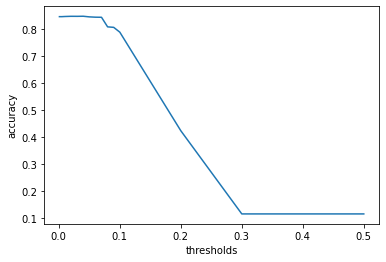

In [16]:
# train accuracy 
plt.plot(thresh_set,train_acc)
plt.xlabel('thresholds')
plt.ylabel('accuracy')
# plt.savefig('../doc/figures/train.png',dpi=300)

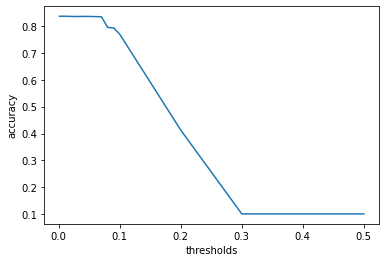

In [17]:
# validate accuracy
plt.plot(thresh_set,validate_acc)
plt.xlabel('thresholds')
plt.ylabel('accuracy')
# plt.savefig('../doc/figures/cross_validation.png',dpi=300)

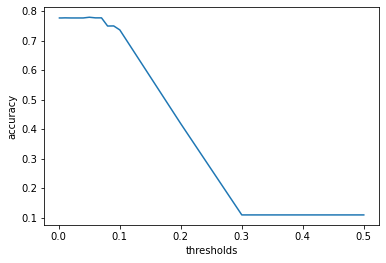

In [18]:
# test accuracy
plt.plot(thresh_set,test_acc)
plt.xlabel('thresholds')
plt.ylabel('accuracy')
# plt.savefig('../doc/figures/test.png',dpi=300)